In [1]:
from pathlib import Path

import yaml
import polars as pl
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import scienceplots

In [2]:
plt.style.use(['science','ieee'])

In [3]:
window_size = 100

---

In [4]:
paths = [
    path.parent
    for path in Path('../sweep/').glob('**/**/cartp__times.csv')
]
len(paths)

164

In [5]:
dfs = list()
for elem in paths:
    cpath = elem / '.hydra/config.yaml'
    with open(cpath, 'r') as f:
        cfg = yaml.load(f, yaml.Loader)

    cfg.pop('interactive')

    df = pd.json_normalize(cfg)
    df['path'] = str(elem)
    dfs.append(df)

In [6]:
concat = pl.DataFrame(pd.concat(dfs))

In [7]:
results = list()
for row in concat.iter_rows(named=True):
    path = Path(row['path']) / 'cartp__times.csv'

    try:
        times = (
            pl.read_csv(path, has_header=False)
            .mean_horizontal()
            .rolling_mean(window_size=window_size)
            .slice(length=1, offset=-1)
            .item()
        )
    except FileNotFoundError:
        continue

    results.append({'path': row['path'], 'times': times})

In [8]:
results_df = (
    concat
    .join(pl.DataFrame(results), on='path', how='left')
)

results_df.shape

(164, 13)

In [9]:
for col in results_df.columns[:-3]:
    print(col)
    print(
        results_df
        .group_by(col)
        .agg(
            pl.median('times').alias('times_median'),
            pl.mean('times').alias('times_mean'),
            pl.count('times').alias('count'),
        )
        .sort('times_mean', descending=True)
    )

n_episodes
shape: (6, 4)
┌────────────┬──────────────┬────────────┬───────┐
│ n_episodes ┆ times_median ┆ times_mean ┆ count │
│ ---        ┆ ---          ┆ ---        ┆ ---   │
│ i64        ┆ f64          ┆ f64        ┆ u32   │
╞════════════╪══════════════╪════════════╪═══════╡
│ 1001       ┆ 260.635      ┆ 252.461    ┆ 10    │
│ 501        ┆ 298.6        ┆ 237.088417 ┆ 120   │
│ 1000       ┆ 26.57        ┆ 178.104    ┆ 5     │
│ 500        ┆ 149.205      ┆ 175.916667 ┆ 12    │
│ 300        ┆ 153.465      ┆ 157.1175   ┆ 16    │
│ 700        ┆ 9.5          ┆ 9.5        ┆ 1     │
└────────────┴──────────────┴────────────┴───────┘
model_params.batch_size
shape: (2, 4)
┌─────────────────────────┬──────────────┬────────────┬───────┐
│ model_params.batch_size ┆ times_median ┆ times_mean ┆ count │
│ ---                     ┆ ---          ┆ ---        ┆ ---   │
│ i64                     ┆ f64          ┆ f64        ┆ u32   │
╞═════════════════════════╪══════════════╪════════════╪═══════╡
│ 256

In [10]:
def read_times(path_: str, idx: int):
    aux = pl.read_csv(Path(path_) / 'cartp__times.csv', has_header=False)
    return (
        aux
        .rename({'column_1': 'times'})
        .with_columns(
            runid=pl.lit(f'exec_{idx:02d}'),
            order=pl.int_range(0, aux.shape[0])
        )
    )

In [11]:
def plot_cmp(colname: str, title: str):
    ax = plt.gca()

    opts = list(results_df.select(colname).unique().iter_rows())
    for name, in opts:
        col_paths = (
            results_df
            .filter(pl.col(colname) == name)
            .select('path')
        )

        aux = (
            pl.concat(
                [read_times(elem[0], i)
                for i, elem in enumerate(col_paths.iter_rows())]
            )
            .filter(pl.col('order') < 501)
            .with_columns(
                times_roll=(
                    pl.col('times')
                    .rolling_mean(window_size=window_size, closed='both', min_periods=1)
                    .over('runid')
                )
            )
            .group_by('order')
            .agg(
                pl.count('times_roll').alias('count'),
                pl.mean('times_roll').alias('mean'),
                pl.std('times_roll').alias('std'),
            )
            .sort('order')
            .with_columns(
                mean_roll=(
                    pl.col('mean')
                    .rolling_mean(window_size=window_size, closed='both', min_periods=1)
                ),
                std_roll=(
                    pl.col('std')
                    .rolling_mean(window_size=window_size, closed='both', min_periods=1)
                )
            )
            .with_columns(
                top=pl.col('mean_roll') + pl.col('std_roll'),
                bot=pl.col('mean_roll') - pl.col('std_roll'),
            )
        )

        ax.plot(
            aux.select('order').to_series(),
            aux.select('mean_roll').to_series(),
            label=name,
        )
        ax.fill_between(
            x=aux.select('order').to_series(),
            y1=aux.select('bot').to_series(),
            y2=aux.select('top').to_series(),
            alpha=.2,
        )

    plt.legend()
    plt.ylabel('Total Time')
    plt.xlabel('Episodes')
    plt.title(title)
    plt.show()
    plt.close()

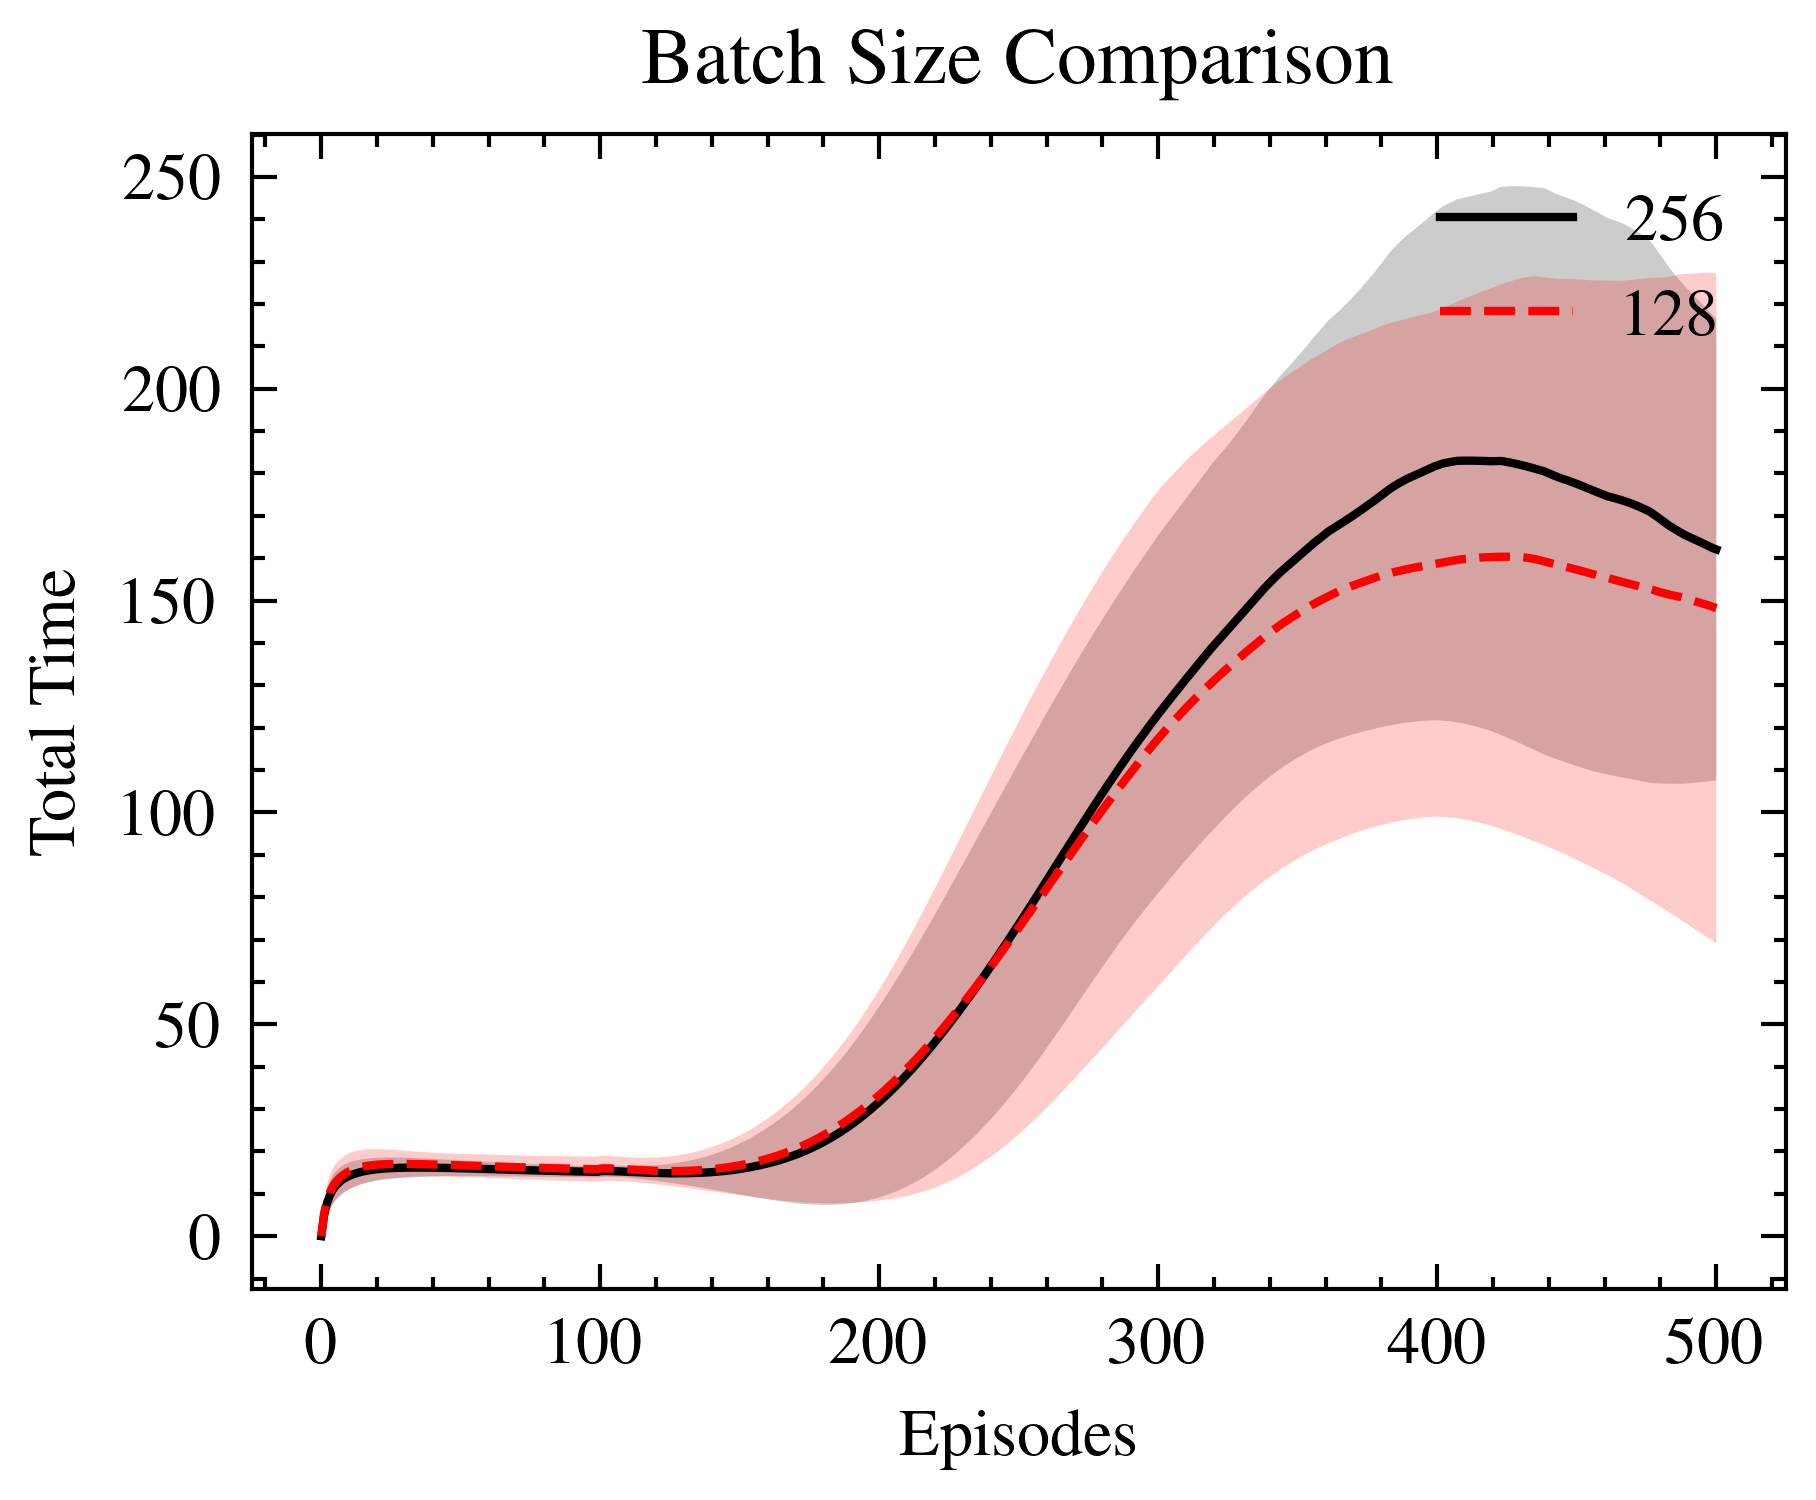

In [12]:
plot_cmp('model_params.batch_size', title='Batch Size Comparison')

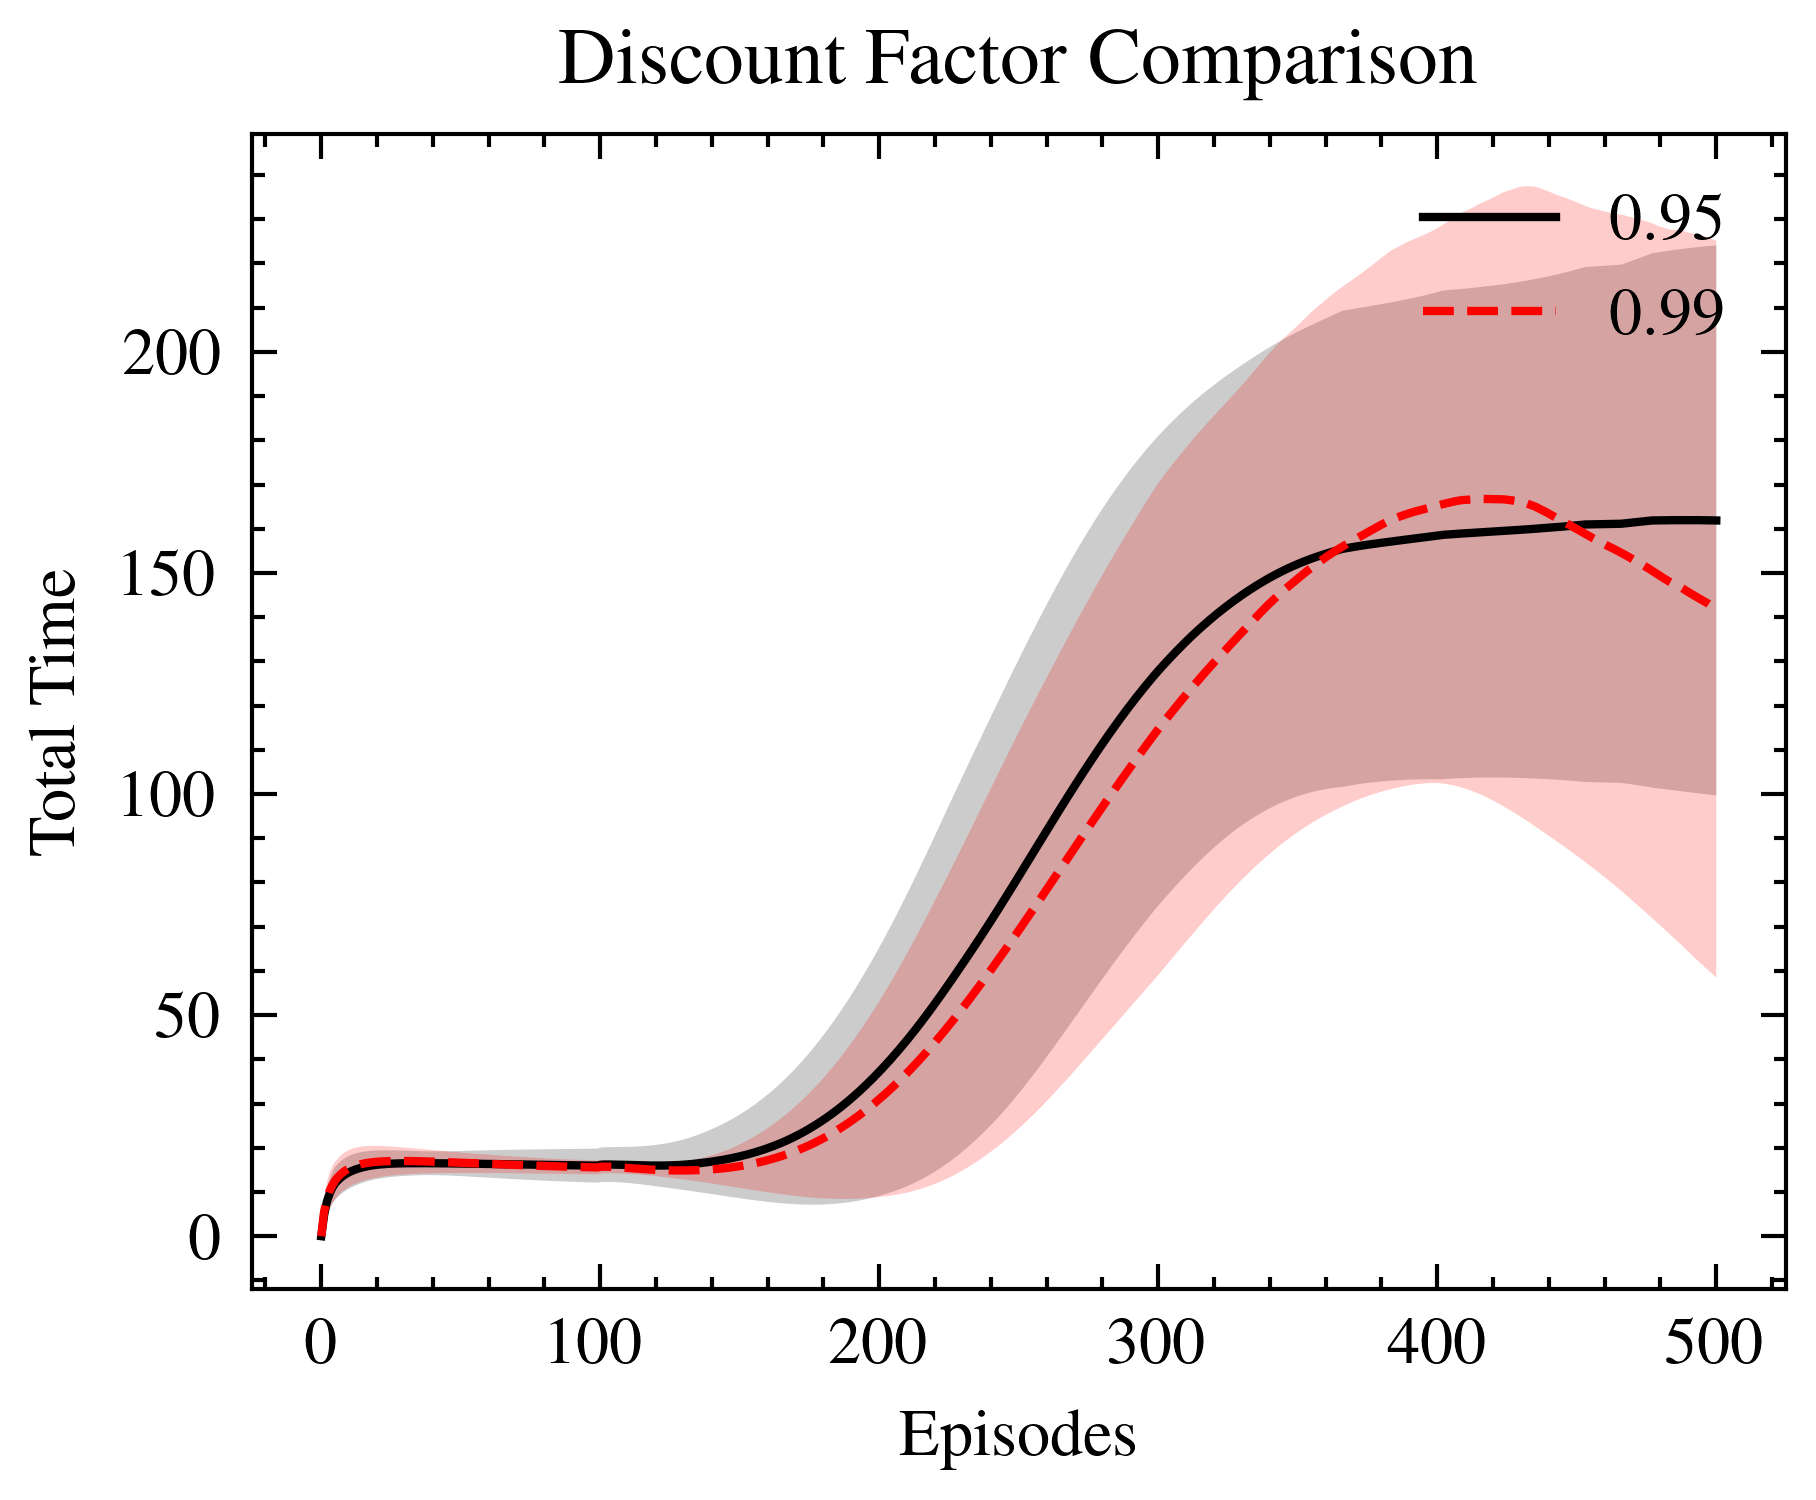

In [13]:
plot_cmp('model_params.gamma', title='Discount Factor Comparison')

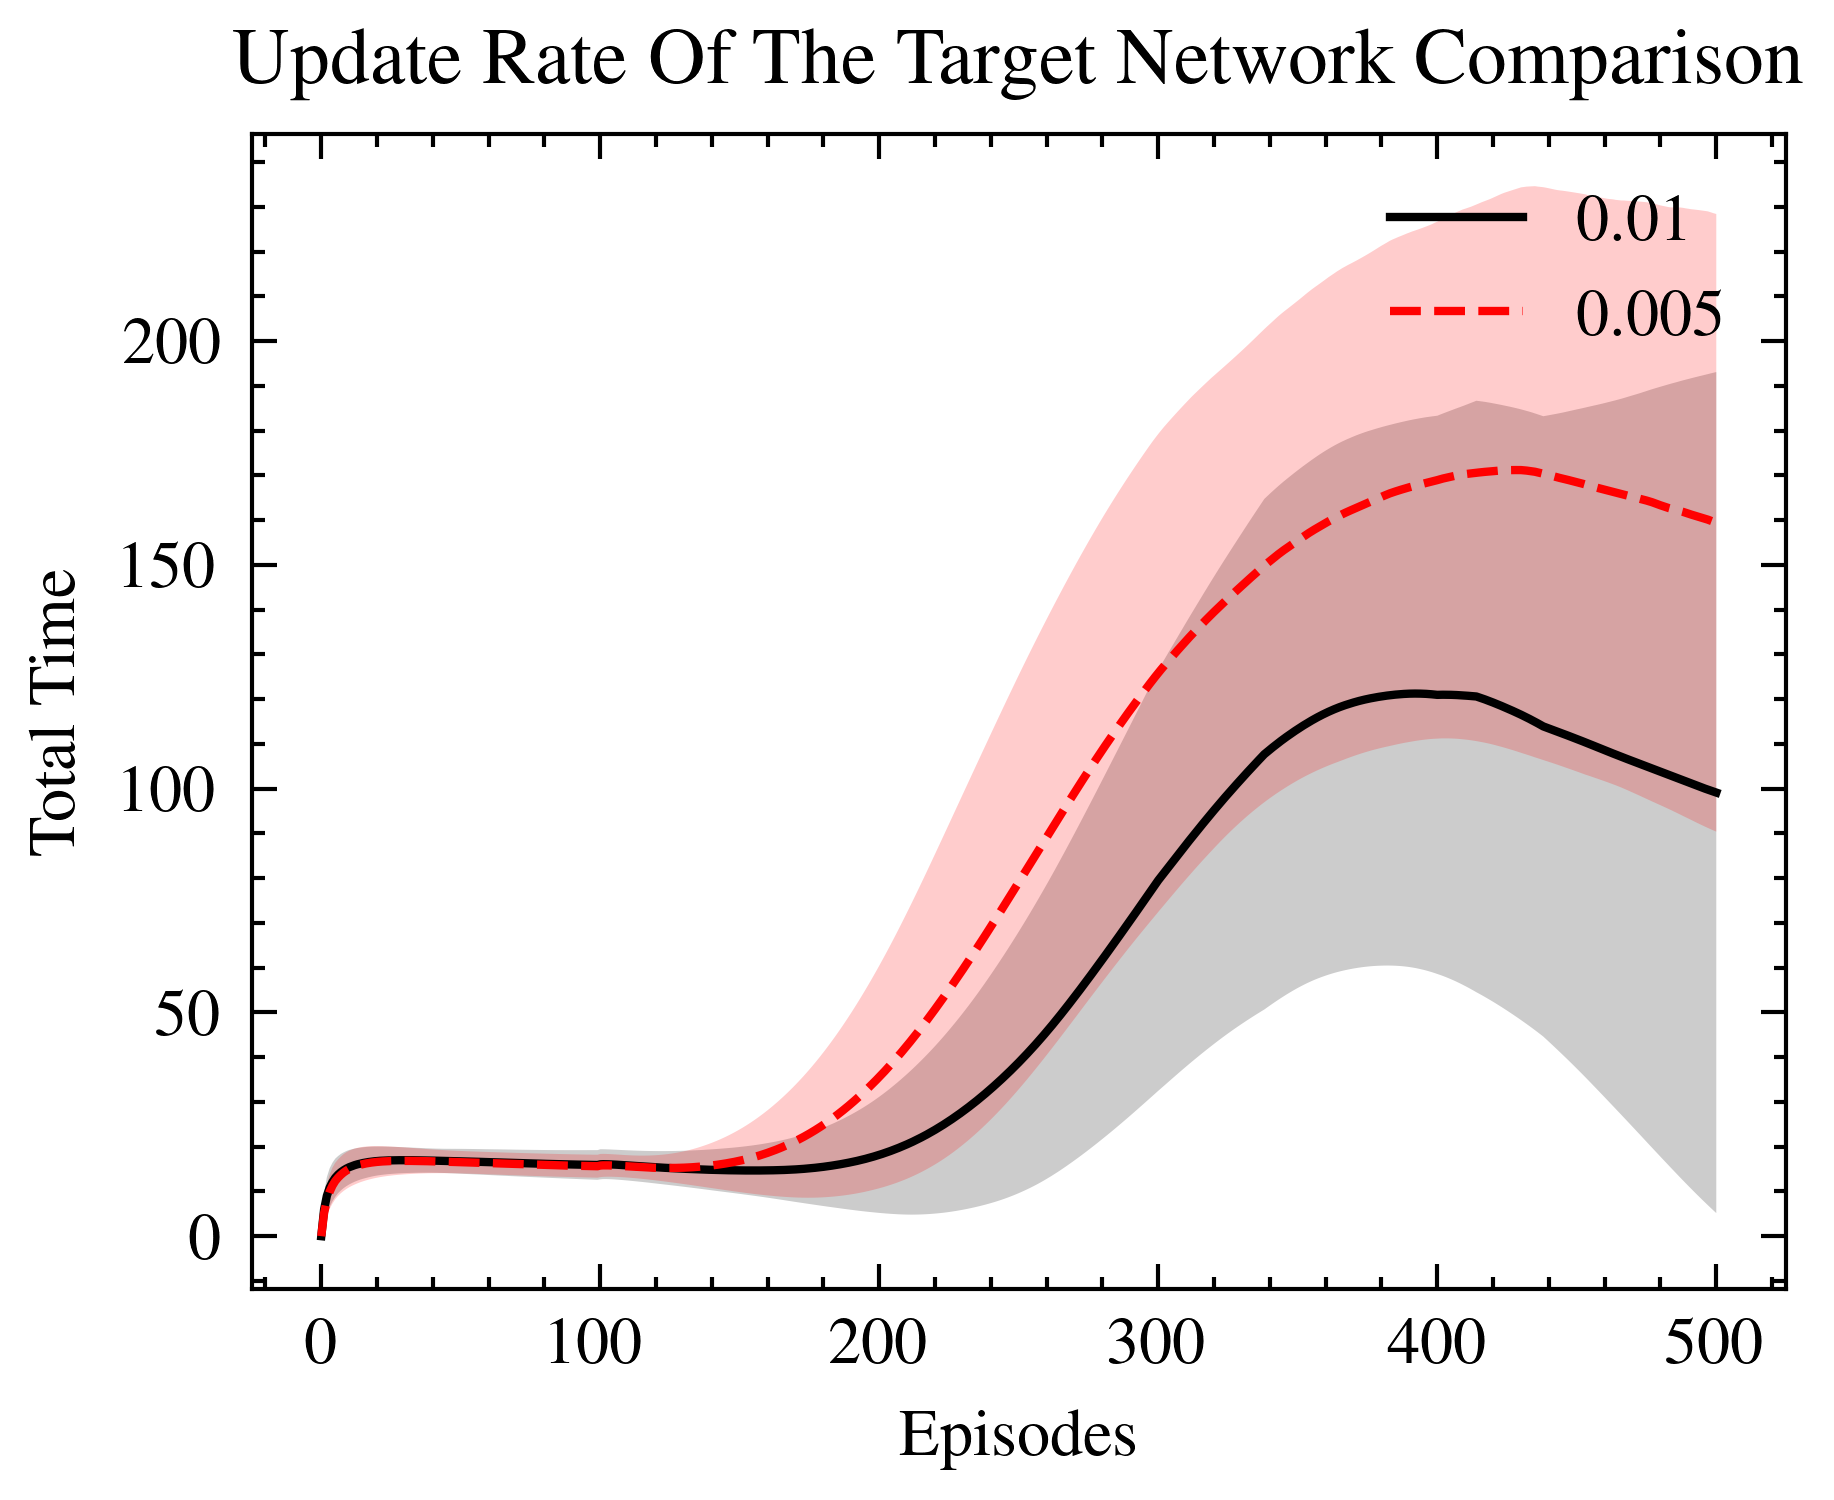

In [14]:
plot_cmp('model_params.tau', title='Update Rate Of The Target Network Comparison')

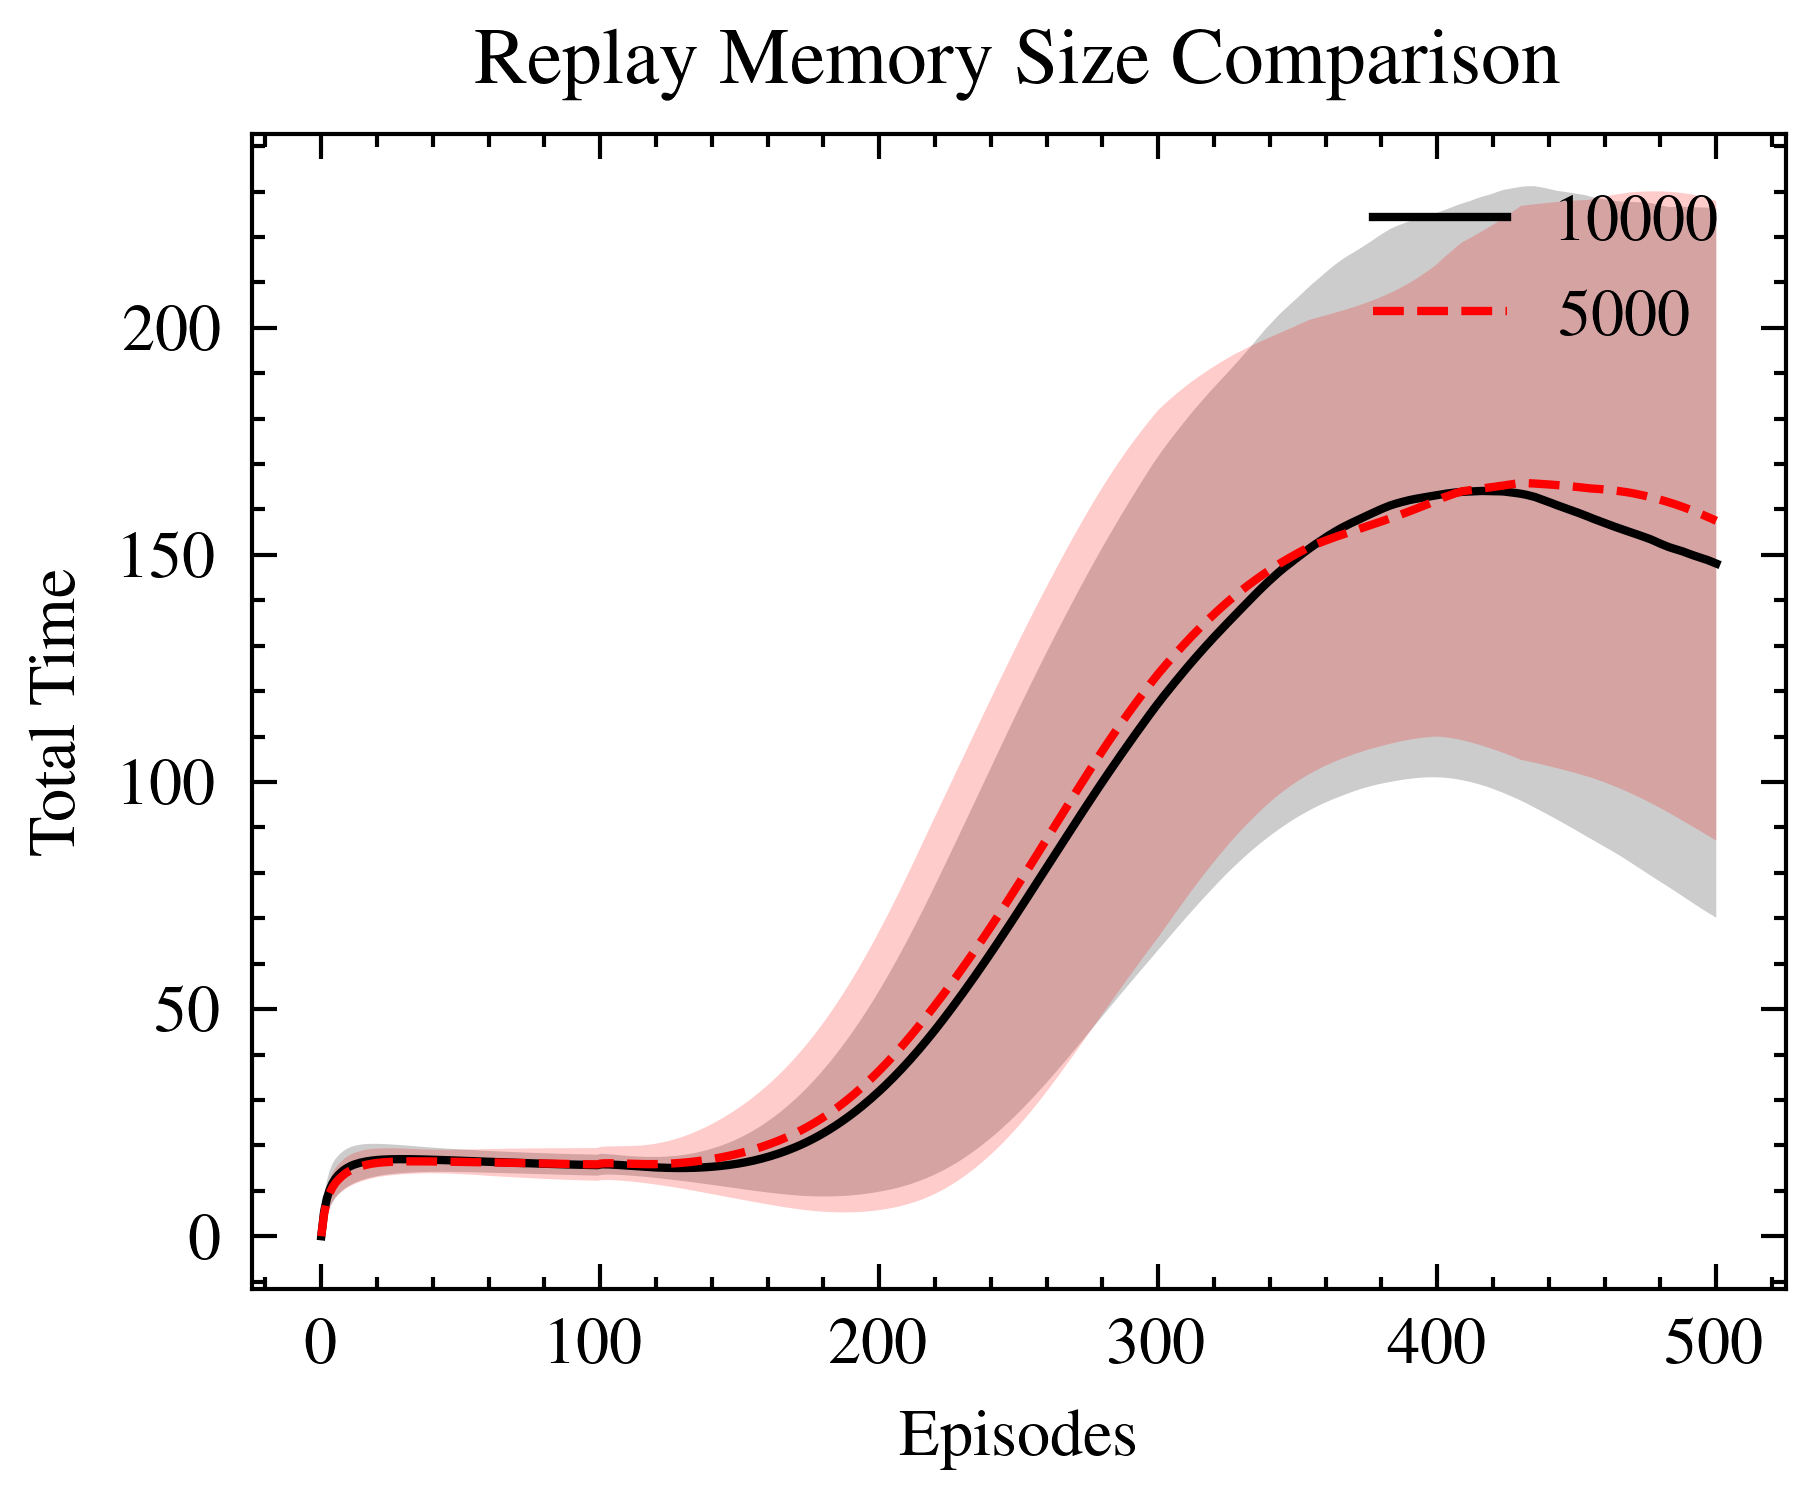

In [15]:
plot_cmp('model_params.memory_size', title='Replay Memory Size Comparison')

---

In [16]:
import math

In [17]:
eps_threshold = [
    0.05
    + (0.9 - 0.05)
    * math.exp(-1. * i / 1000)
    for i in range(int(1E4))
]

Text(0.5, 1.0, 'Exponential Decay Of $\\epsilon$')

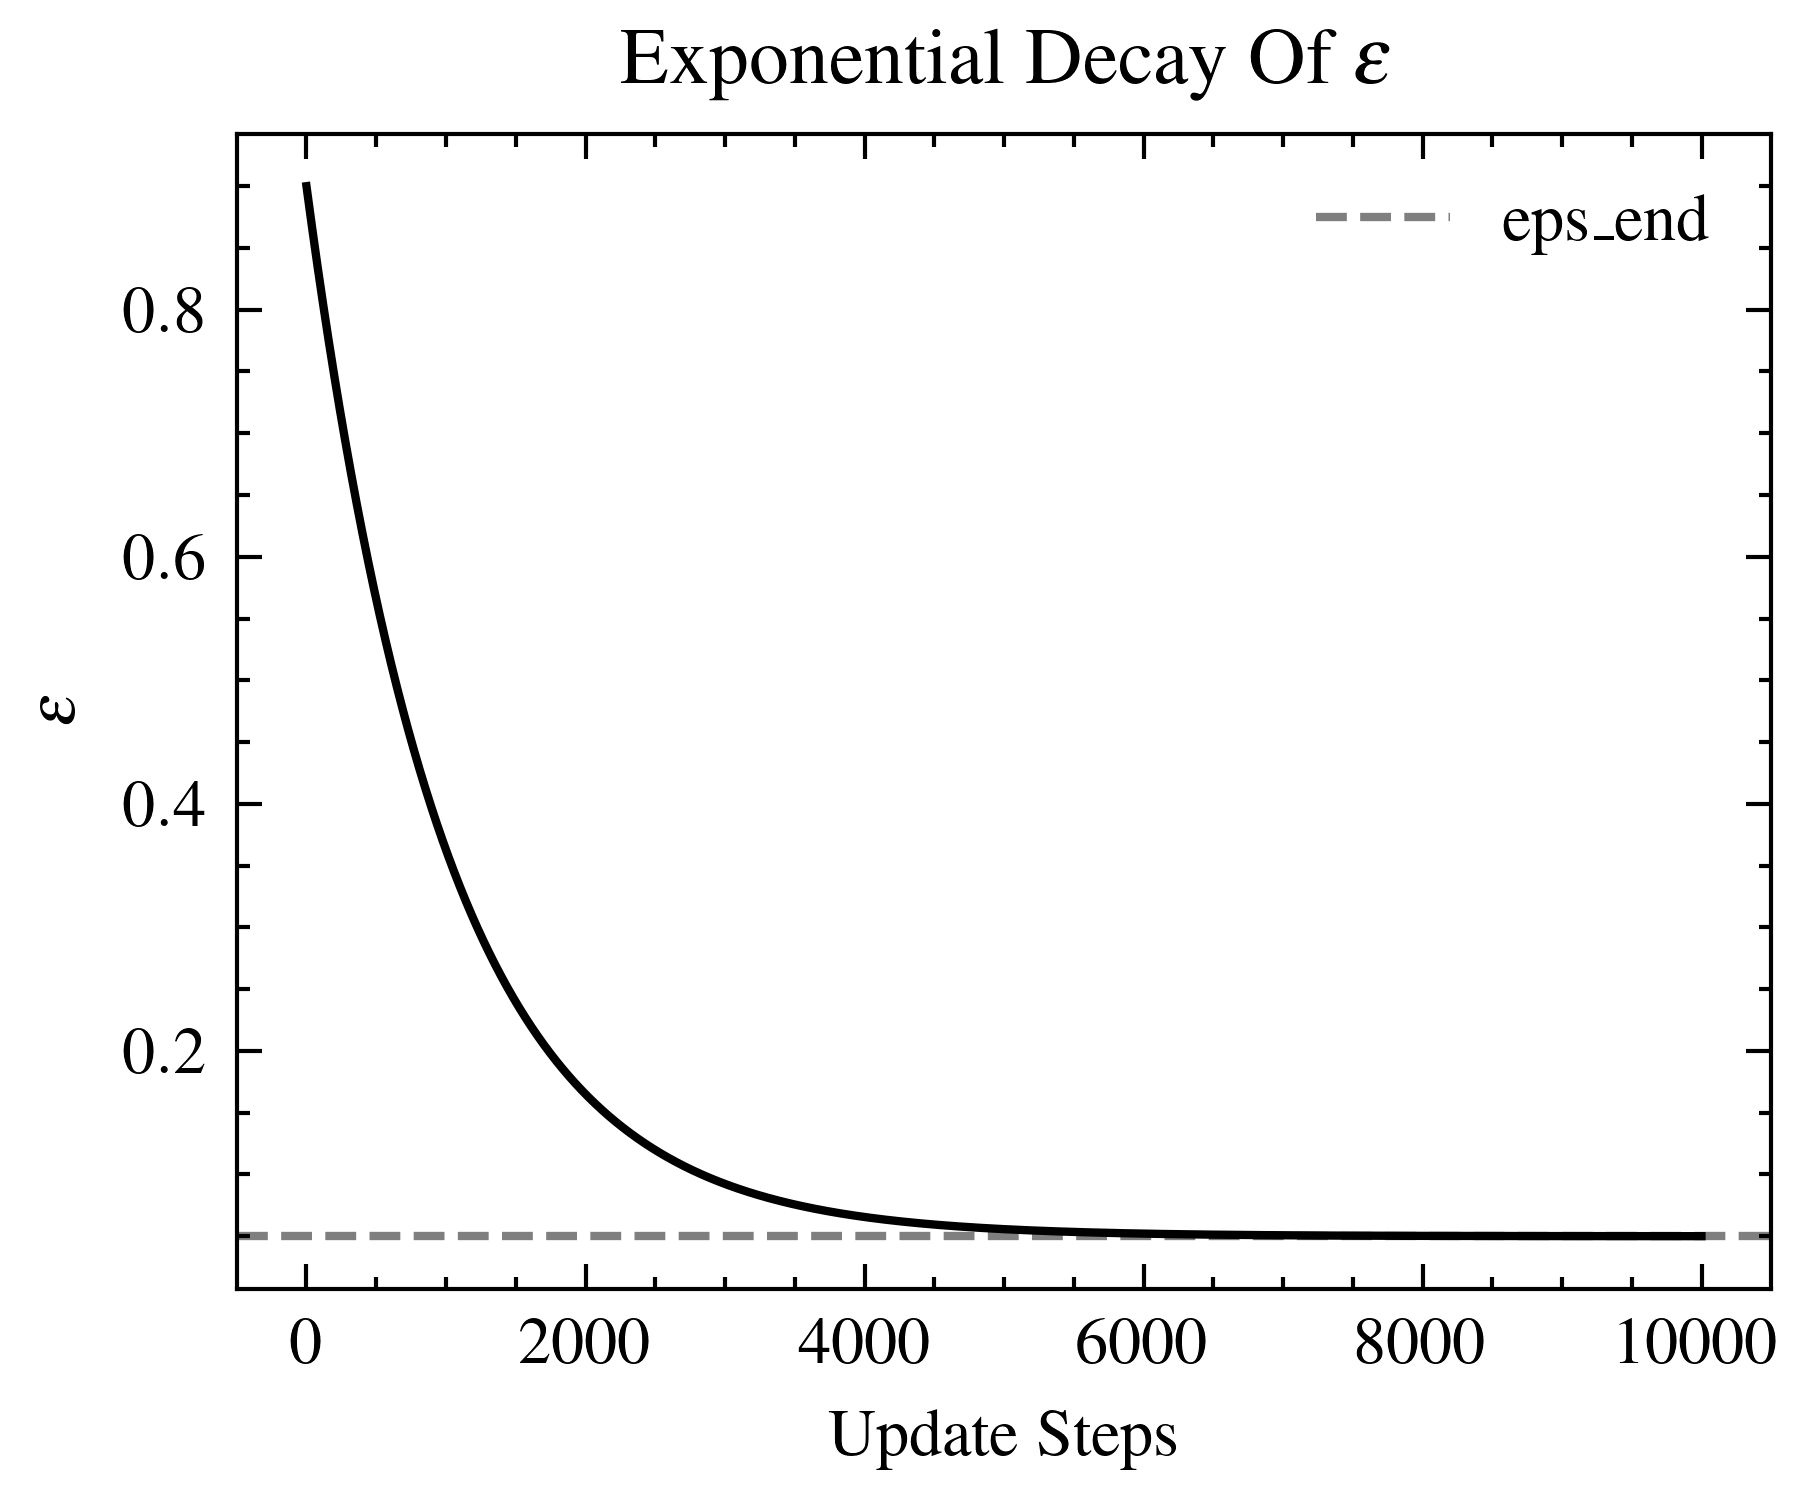

In [18]:
plt.plot(eps_threshold)
plt.axhline(0.05, ls='--', alpha=.5, label='eps_end')
plt.legend()
plt.xlabel('Update Steps')
plt.ylabel('$\\epsilon$')
plt.title('Exponential Decay Of $\\epsilon$')